In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import re
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import cellbayesassay as cba
import pickle
import itertools
import os.path
import os
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
my_treatments = ['TI21', 'TI22', 'TI26']

concentrations = {
    ('TI21', 1): 100e-6,
    ('TI21', 2): 10e-6,
    ('TI21', 3): 1e-6,
    ('TI22', 1): 10e-6,
    ('TI22', 2): 3e-6,
    ('TI22', 3): 1e-6,
    ('TI26', 1): 10e-6,
    ('TI26', 2): 3e-6,
    ('TI26', 3): 1e-6,
}



def get_concentration(TI, conc, concentrations=concentrations):
    TI = TI.strip()
    if re.match('^TI.*', TI):
        val = concentrations[(TI, conc)]
    else:
        val = concentrations[TI]
    return(val)

fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum-edited.xlsx'
datad = {}

def read_data(sheet_name, assays, mean_sem_col='Group', skiprows=0):
    data = pd.read_excel(fpath, sheet_name=sheet_name, skiprows=skiprows)
    data = data.loc[~ data[mean_sem_col].isin(['mean', 'SEM'])]
    data['TI'] = data.TI.apply(lambda s: re.sub('TI\\s+', 'TI', s)).str.strip()
    data = data.applymap(lambda x: 0 if x == '<LOD' else x)
    data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
    data_nonassays = data.loc[:, ~ data.columns.isin(assays)]
    data_assays = pd.concat([data[a].astype(np.float64).to_frame(a) for a in assays], axis=1)
    data = pd.concat([data_nonassays, data_assays], axis=1)
    return(data)

def add_concentrations(data, concentrations):
    data['concentration'] = data.apply(lambda r: get_concentration(r.loc['TI'], r.loc['conc'], concentrations=concentrations), axis=1)
    data['conc_log10'] = data.concentration.apply(np.log10)
    return(data)

assayd = {}

In [3]:
concentrations_LPS = concentrations.copy()
concentrations_LPS.update({
    'LPS': 1e-9,
    #'VC+L': 1e-9,
})
sheet_name = 'LPS'
assays_LPS = ['IFN-γ', 'IL-10', 'IL-12p70', 'IL-1β', 'IL-2', 'IL-4', 'IL-5', 'IL-6', 'KC/GRO', 'TNF-α']
assayd.update({sheet_name: assays_LPS})

data = read_data(sheet_name=sheet_name, assays=assays_LPS, mean_sem_col='Group', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_LPS)
datad[sheet_name] = data
data

,Cohort,Group,IRN,TI,conc,IFN-γ,IL-10,IL-12p70,IL-1β,IL-2,IL-4,IL-5,IL-6,KC/GRO,TNF-α,concentration,conc_log10
0,2.0,I1,TI 21 C1_1,TI21,1.0,0.000,6.53,48.48,0.61,0.50,0.000,0.00,12938.0,9.36,1734.0,1.000000e-04,-4.0
1,2.0,I1,TI 21 C1_2,TI21,1.0,0.197,8.05,61.95,1.71,1.39,0.000,0.13,13352.0,7.25,1601.0,1.000000e-04,-4.0
2,2.0,I1,TI 21 C1_3,TI21,1.0,0.023,6.97,143.32,0.84,0.46,0.026,0.65,13167.0,9.89,1333.0,1.000000e-04,-4.0
3,2.0,I1,TI 21 C1_4,TI21,1.0,0.038,6.25,4.21,0.72,0.00,0.000,0.00,8040.0,6.21,1670.0,1.000000e-04,-4.0
4,2.0,I1,TI 21 C1_5,TI21,1.0,0.004,5.60,23.70,0.90,0.00,0.000,0.00,6801.0,6.78,1272.0,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,5.0,LPS 5,VC+LPS_5_2,LPS,NaN,0.019,6.87,44.88,1.52,0.00,0.081,0.17,19845.0,13.87,1989.0,1.000000e-09,-9.0
90,5.0,LPS 5,VC+LPS_5_3,LPS,NaN,0.000,8.26,18.15,1.42,1.59,0.000,0.00,21097.0,12.33,2243.0,1.000000e-09,-9.0
91,5.0,LPS 5,VC+LPS_5_4,LPS,NaN,0.000,7.52,56.22,1.44,0.00,0.000,1.84,21231.0,25.92,2156.0,1.000000e-09,-9.0
92,5.0,LPS 5,VC+LPS_5_5,LPS,NaN,0.012,8.55,82.39,2.39,0.64,0.197,2.00,26174.0,21.33,2811.0,1.000000e-09,-9.0


In [4]:
concentrations_Ab_toxicity = concentrations.copy()
concentrations_Ab_toxicity.update({
    'LC': 1e-9,
})
sheet_name = 'Abeta Toxicity'
assays_Ab_toxicity = ['Viability [% VC]']
assayd.update({sheet_name: assays_Ab_toxicity})

data = read_data(sheet_name=sheet_name, assays=assays_Ab_toxicity, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_Ab_toxicity)
datad[sheet_name] = data
data

,IRN,TI,conc,Viability [% VC],concentration,conc_log10
0,TI 21 C1_1,TI21,1.0,76.3,1.000000e-04,-4.0
1,TI 21 C1_2,TI21,1.0,83.8,1.000000e-04,-4.0
2,TI 21 C1_3,TI21,1.0,81.7,1.000000e-04,-4.0
3,TI 21 C1_4,TI21,1.0,99.6,1.000000e-04,-4.0
4,TI 21 C1_5,TI21,1.0,86.2,1.000000e-04,-4.0
...,...,...,...,...,...,...
81,LC_2_2,LC,NaN,74.7,1.000000e-09,-9.0
82,LC_2_3,LC,NaN,65.4,1.000000e-09,-9.0
83,LC_2_4,LC,NaN,73.9,1.000000e-09,-9.0
84,LC_2_5,LC,NaN,68.6,1.000000e-09,-9.0


In [5]:
concentrations_Ab_release = concentrations.copy()
concentrations_Ab_release.update({
    'VC': 1e-9,
})
sheet_name = 'Abeta release'
assays_Ab_release = ['Aβ38', 'Aβ40', 'Aβ42']
assayd.update({sheet_name: assays_Ab_release})

data = read_data(sheet_name=sheet_name, assays=assays_Ab_release, mean_sem_col='Group', skiprows=1)
data['TI'] = data.TI.apply(lambda s: re.sub('^VC.*', 'VC', s))
data = add_concentrations(data, concentrations=concentrations_Ab_release)
datad[sheet_name] = data
data

,plate,Group,ID,TI,conc,Aβ38,Aβ40,Aβ42,concentration,conc_log10
0,1.0,A1,TI21 c1_1,TI21,1.0,3401.0,14276.0,1128.0,1.000000e-04,-4.0
1,1.0,A1,TI21 c1_2,TI21,1.0,3468.0,14353.0,1011.0,1.000000e-04,-4.0
2,1.0,A1,TI21 c1_3,TI21,1.0,3190.0,13622.0,970.0,1.000000e-04,-4.0
3,1.0,A1,TI21 c1_4,TI21,1.0,4390.0,19144.0,1262.0,1.000000e-04,-4.0
4,1.0,A1,TI21 c1_5,TI21,1.0,3782.0,15602.0,1163.0,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...,...
81,5.0,K,VC_4_2,VC,NaN,3016.0,15962.0,1406.0,1.000000e-09,-9.0
82,5.0,K,VC_4_3,VC,NaN,2296.0,13190.0,1304.0,1.000000e-09,-9.0
83,5.0,K,VC_4_4,VC,NaN,2517.0,12753.0,1269.0,1.000000e-09,-9.0
84,5.0,K,VC_4_5,VC,NaN,3121.0,16302.0,1644.0,1.000000e-09,-9.0


In [6]:
concentrations_Ab_clearance = concentrations.copy()
concentrations_Ab_clearance.update({
    'Aß': 1e-9,
})
sheet_name = 'Abeta clearance'
assays_Ab_clearance = ['Aβ42 SN', 'Aβ42 Ly']
assayd.update({sheet_name: assays_Ab_clearance})

data = read_data(sheet_name=sheet_name, assays=assays_Ab_clearance, mean_sem_col='Group', skiprows=1)
data['conc'] = data.conc.str.replace('c', '').astype(np.float64)
data = add_concentrations(data, concentrations=concentrations_Ab_clearance)
datad[sheet_name] = data
data

,plate,Group,IRN,TI,conc,Aβ42 SN,Aβ42 Ly,concentration,conc_log10
0,2.0,B4,TI21_c1_1,TI21,1.0,14356.0,23798.0,1.000000e-04,-4.0
1,2.0,B4,TI21_c1_2,TI21,1.0,21196.0,48934.0,1.000000e-04,-4.0
2,2.0,B4,TI21_c1_3,TI21,1.0,24232.0,16946.0,1.000000e-04,-4.0
3,2.0,B4,TI21_c1_4,TI21,1.0,33126.0,56506.0,1.000000e-04,-4.0
4,2.0,B4,TI21_c1_5,TI21,1.0,29952.0,24963.0,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...
89,5.0,E7,5_Aß_2,Aß,NaN,24292.0,3212.0,1.000000e-09,-9.0
90,5.0,E7,5_Aß_3,Aß,NaN,NaN,6464.0,1.000000e-09,-9.0
91,5.0,E7,5_Aß_4,Aß,NaN,15038.0,14282.0,1.000000e-09,-9.0
92,5.0,E7,5_Aß_5,Aß,NaN,15654.0,7222.0,1.000000e-09,-9.0


In [7]:
concentrations_GF_withdrawal = concentrations.copy()
concentrations_GF_withdrawal.update({
    'VC': 1e-9,
})
sheet_name = 'GF withdrawal'
assays_GF_withdrawal = ['PI', 'YOPRO', 'MTT', 'LDH']
assayd.update({sheet_name: assays_GF_withdrawal})

data = read_data(sheet_name=sheet_name, assays=assays_GF_withdrawal, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_GF_withdrawal)
datad[sheet_name] = data
data

,IRN,TI,conc,PI,YOPRO,MTT,LDH,concentration,conc_log10
0,TI 21 C1_1,TI21,1.0,97.6,85.0,80.8,105.3,1.000000e-04,-4.0
1,TI 21 C1_2,TI21,1.0,82.6,74.3,103.3,119.0,1.000000e-04,-4.0
2,TI 21 C1_3,TI21,1.0,105.1,85.6,101.4,120.0,1.000000e-04,-4.0
3,TI 21 C1_4,TI21,1.0,129.2,111.9,93.0,120.0,1.000000e-04,-4.0
4,TI 21 C1_5,TI21,1.0,107.4,94.6,100.5,119.5,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...
89,VC_3_2,VC,NaN,108.1,102.2,127.3,96.9,1.000000e-09,-9.0
90,VC_3_3,VC,NaN,92.3,100.1,104.7,103.1,1.000000e-09,-9.0
91,VC_3_4,VC,NaN,95.3,94.7,112.5,102.6,1.000000e-09,-9.0
92,VC_3_5,VC,NaN,97.1,100.5,97.7,97.4,1.000000e-09,-9.0


In [8]:
concentrations_Tau_phosphorylation = concentrations.copy()
concentrations_Tau_phosphorylation.update({
    'VC': 1e-9,
})
sheet_name = 'Tau phosphorylation'
assays_Tau_phosphorylation = ['Tau [pg/µg prot]', 'pTau (T231)', 'ratio']
assayd.update({sheet_name: assays_Tau_phosphorylation})

data = read_data(sheet_name=sheet_name, assays=assays_Tau_phosphorylation, mean_sem_col='Group', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_Tau_phosphorylation)
datad[sheet_name] = data
data

,Cohort,Group,IRN,TI,conc,Tau [pg/µg prot],pTau (T231),ratio,concentration,conc_log10
0,3.0,E1,TI21_c1_1,TI21,1.0,388833.0,48.0,1.22,1.000000e-04,-4.000000
1,3.0,E1,TI21_c1_2,TI21,1.0,362000.0,46.0,1.27,1.000000e-04,-4.000000
2,3.0,E1,TI21_c1_3,TI21,1.0,580648.0,56.0,0.96,1.000000e-04,-4.000000
3,3.0,E1,TI21_c1_4,TI21,1.0,349775.0,40.0,1.13,1.000000e-04,-4.000000
4,3.0,E1,TI21_c1_5,TI21,1.0,389880.0,44.0,1.14,1.000000e-04,-4.000000
5,3.0,E1,TI21_c1_6,TI21,1.0,584470.0,56.0,0.96,1.000000e-04,-4.000000
8,3.0,E2,TI21_c2_3,TI21,2.0,625281.0,60.0,0.97,1.000000e-05,-5.000000
9,3.0,E2,TI21_c2_4,TI21,2.0,412764.0,45.0,1.08,1.000000e-05,-5.000000
10,3.0,E2,TI21_c2_5,TI21,2.0,617010.0,47.0,0.76,1.000000e-05,-5.000000
11,3.0,E2,TI21_c2_6,TI21,2.0,555671.0,46.0,0.83,1.000000e-05,-5.000000


In [9]:
concentrations_NOG = concentrations.copy()
concentrations_NOG.update({
    'VC': 1e-9,
})
sheet_name = 'NOG'
assays_NOG = ['total neurite length', 'Number of branch points', 'Neurogenesis', 'average neurite length']
assayd.update({sheet_name: assays_NOG})

data = read_data(sheet_name=sheet_name, assays=assays_NOG, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_NOG)
datad[sheet_name] = data
data

,IRN,TI,conc,total neurite length,Number of branch points,Neurogenesis,average neurite length,concentration,conc_log10
0,TI 21 C1_1,TI21,1.0,103.16050,2496.377,9.15,44.3,1.000000e-04,-4.0
1,TI 21 C1_2,TI21,1.0,86.85951,2097.451,16.09,38.8,1.000000e-04,-4.0
2,TI 21 C1_3,TI21,1.0,90.33200,2178.649,7.94,39.8,1.000000e-04,-4.0
3,TI 21 C1_4,TI21,1.0,101.73460,2635.384,8.26,41.8,1.000000e-04,-4.0
4,TI 21 C1_5,TI21,1.0,95.91431,2441.658,7.97,41.1,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...
81,VC_2_2,VC,NaN,101.94750,2458.427,7.74,37.8,1.000000e-09,-9.0
82,VC_2_3,VC,NaN,100.02430,2350.311,7.83,35.0,1.000000e-09,-9.0
83,VC_2_4,VC,NaN,89.03091,2184.385,7.43,32.7,1.000000e-09,-9.0
84,VC_2_5,VC,NaN,93.77637,2310.594,9.58,33.4,1.000000e-09,-9.0


In [10]:
def get_treatment_data(compound='TI21', data=data, my_treatments=my_treatments):
    mt = my_treatments.copy()
    mt.remove(compound)
    data = data.loc[~ data.TI.isin(mt)]
    return(data)

def data_plotter(assay, data, group_var=None):
    if group_var is not None:
        groups = data[group_var].unique()
        groupd = dict(zip(groups, ['C' + str(i) for i in range(len(groups))]))
        data['color'] = data[group_var].apply(lambda x: groupd[x])
    else:
        data['color'] = 'C0'
    fig, ax = plt.subplots(1, len(my_treatments), sharey=True)
    for axi, compound in zip(ax, my_treatments):
        axi.scatter(x='concentration', y=assay, c='color', data=get_treatment_data(compound, data=data), marker='+')
        axi.set_xscale('log')
        axi.set_title(compound)
    fig.suptitle(assay)
    return((fig, ax))


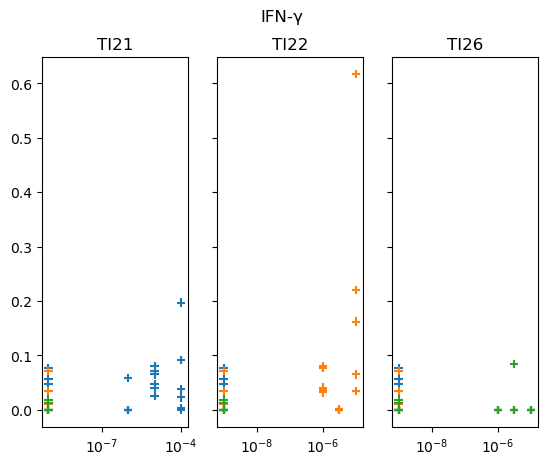

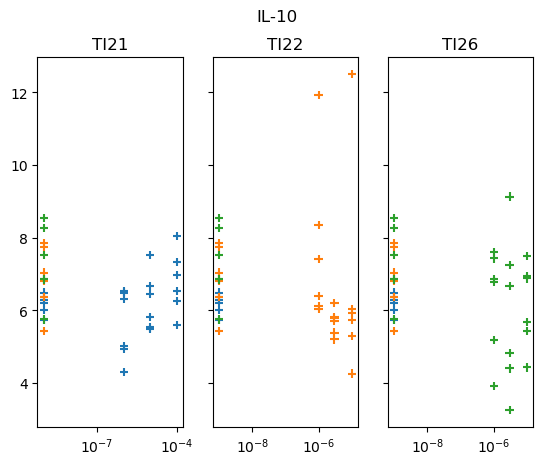

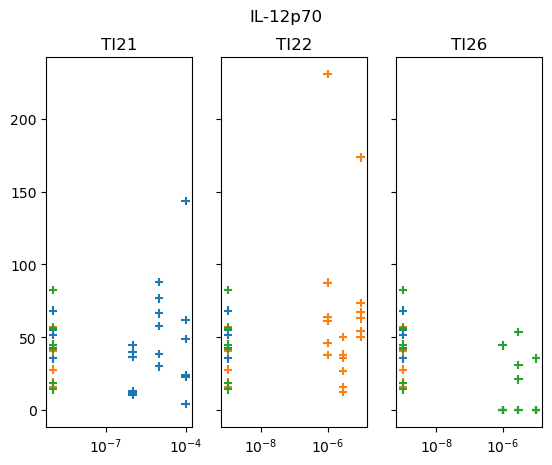

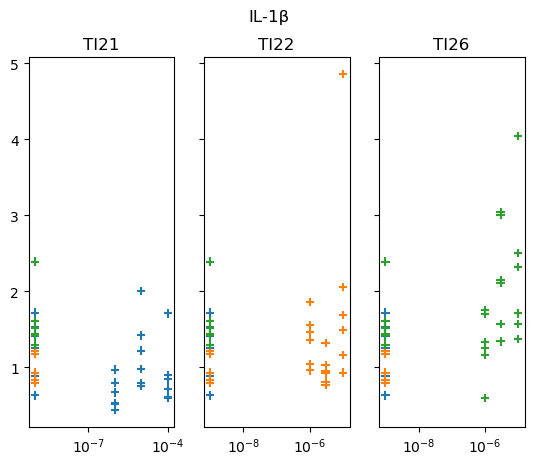

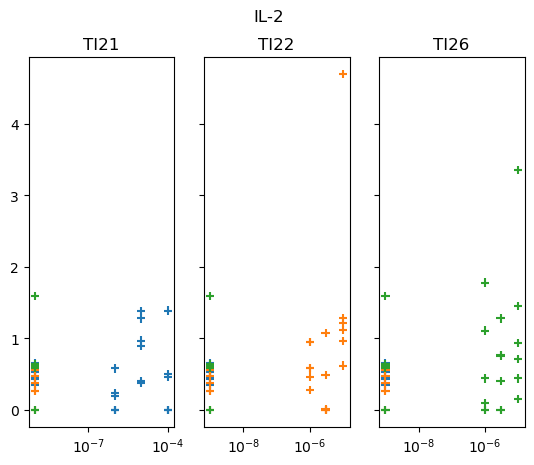

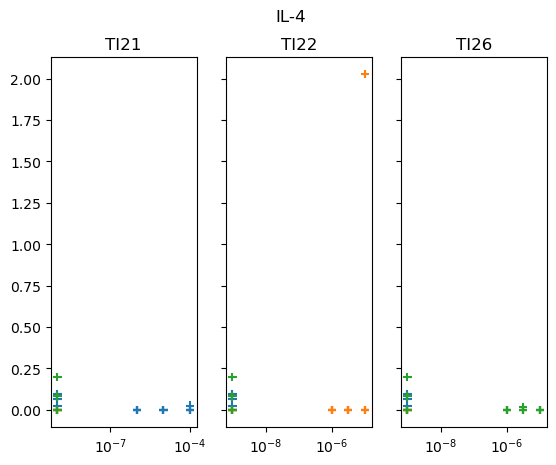

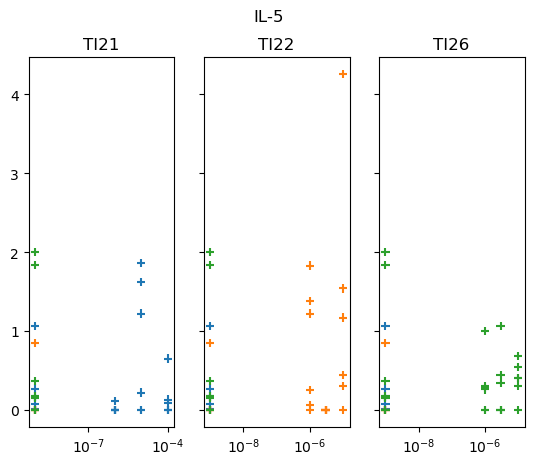

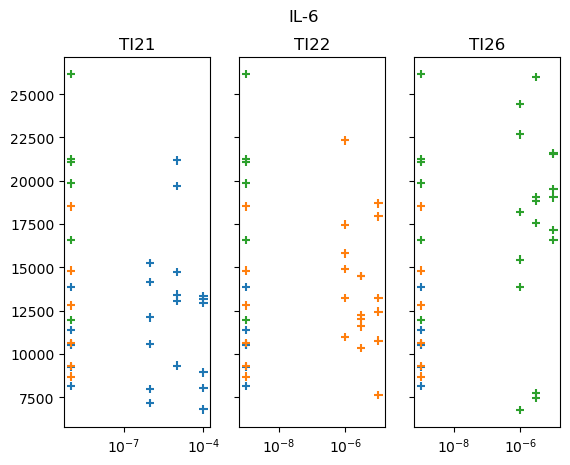

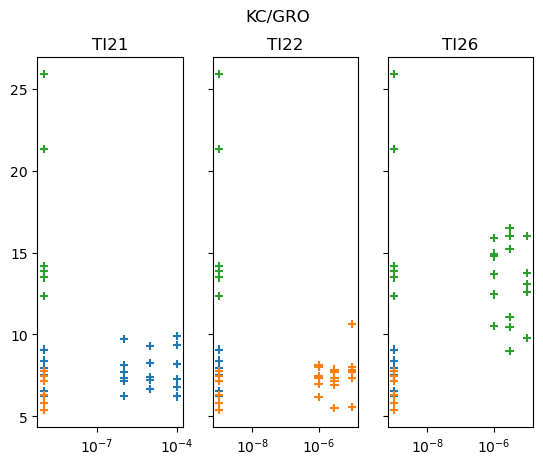

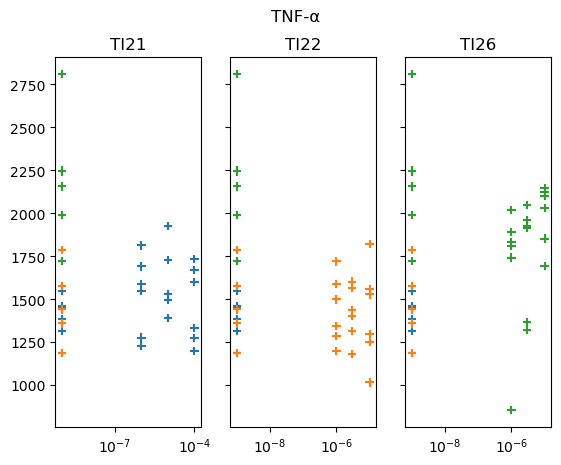

In [11]:
for assay in assays_LPS:
    fig, ax = data_plotter(assay, datad['LPS'], 'Cohort')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

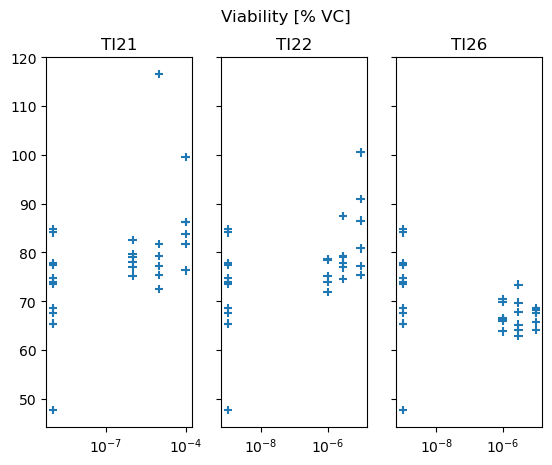

In [12]:
for assay in ['Viability [% VC]']:
    fig, ax = data_plotter(assay, datad['Abeta Toxicity'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

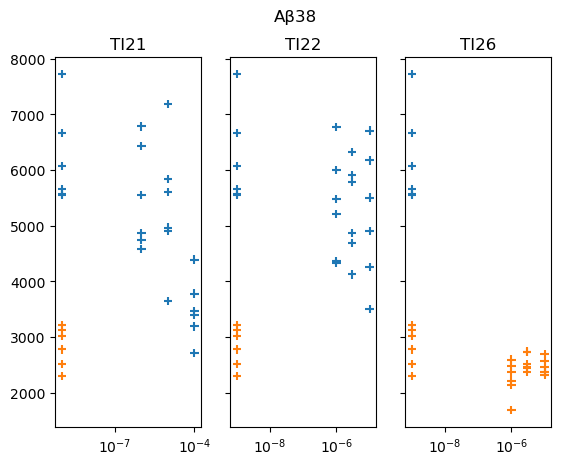

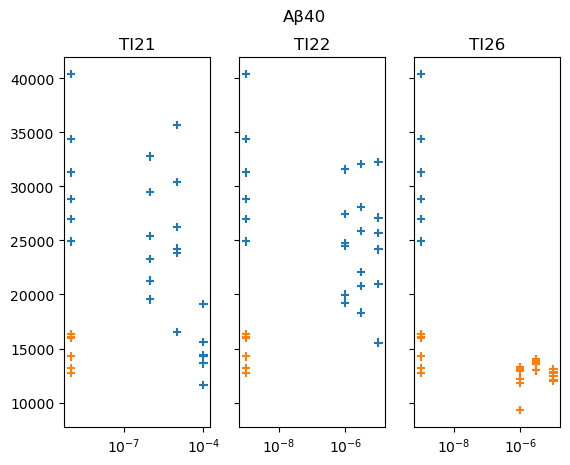

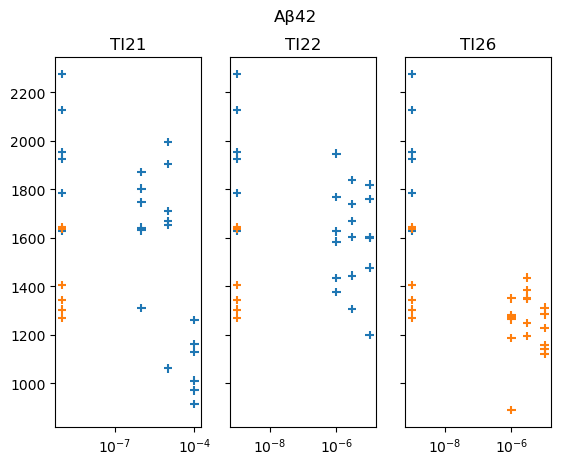

In [13]:
for assay in ['Aβ38', 'Aβ40', 'Aβ42']:
    fig, ax = data_plotter(assay, datad['Abeta release'], 'plate')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

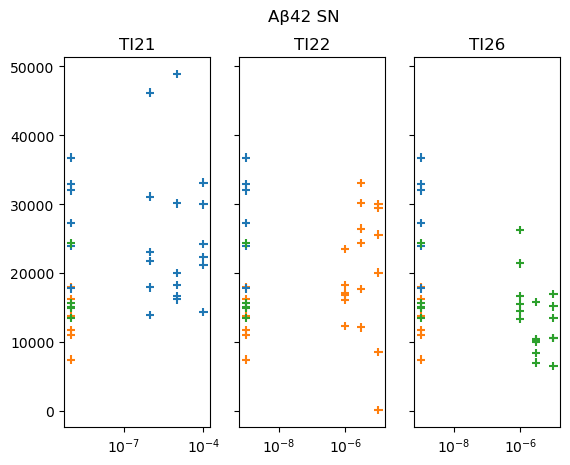

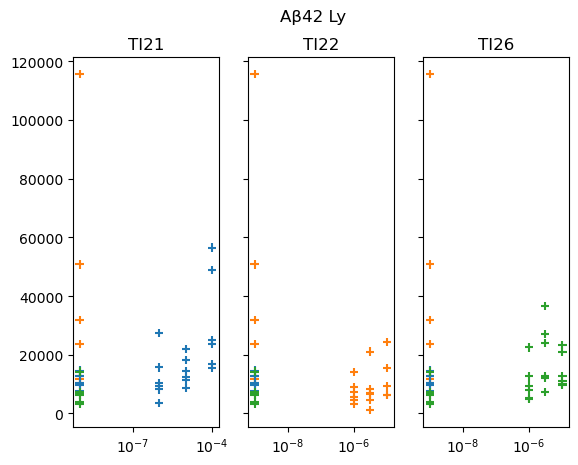

In [14]:
for assay in ['Aβ42 SN', 'Aβ42 Ly']:
    fig, ax = data_plotter(assay, datad['Abeta clearance'], 'plate')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

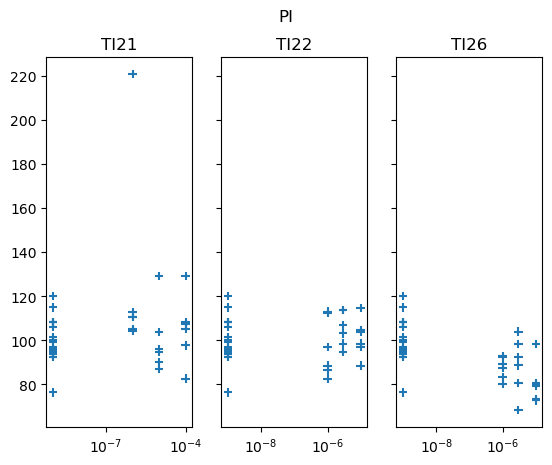

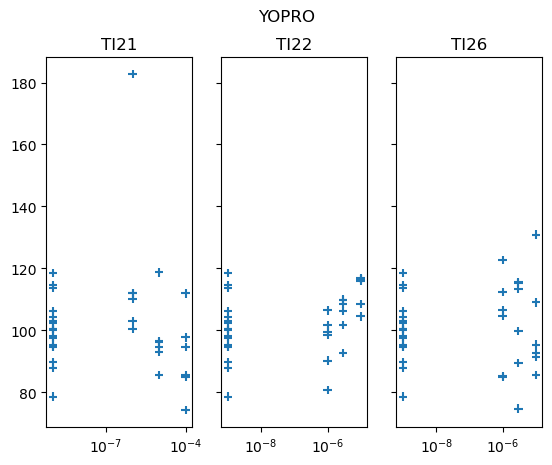

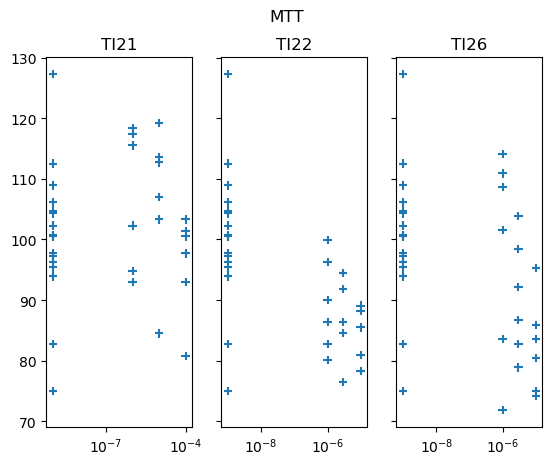

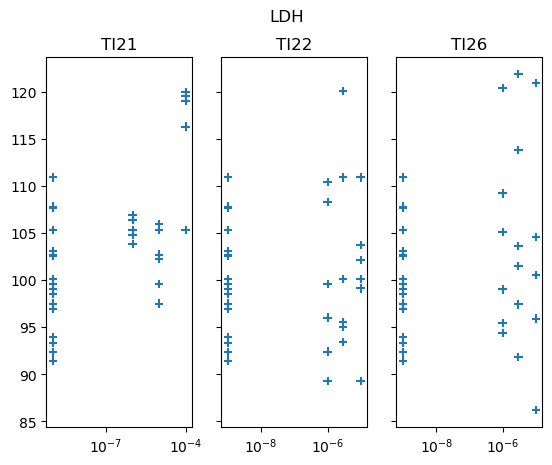

In [15]:
for assay in assays_GF_withdrawal:
    fig, ax = data_plotter(assay, datad['GF withdrawal'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

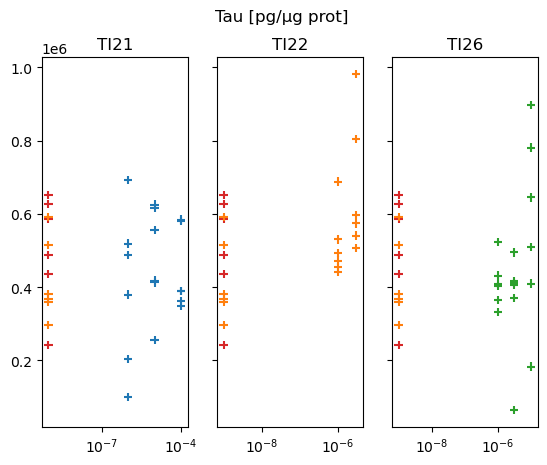

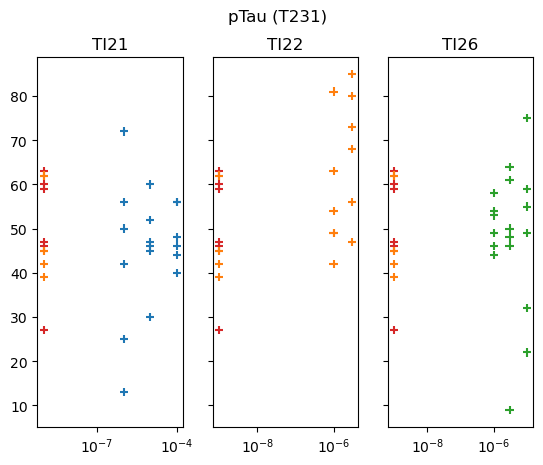

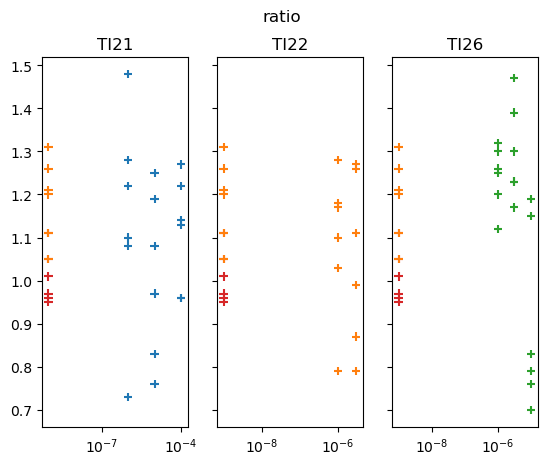

In [16]:
for assay in assays_Tau_phosphorylation:
    fig, ax = data_plotter(assay, datad['Tau phosphorylation'], 'Cohort')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

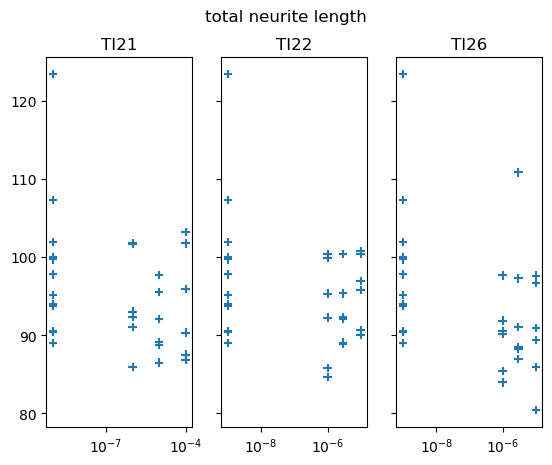

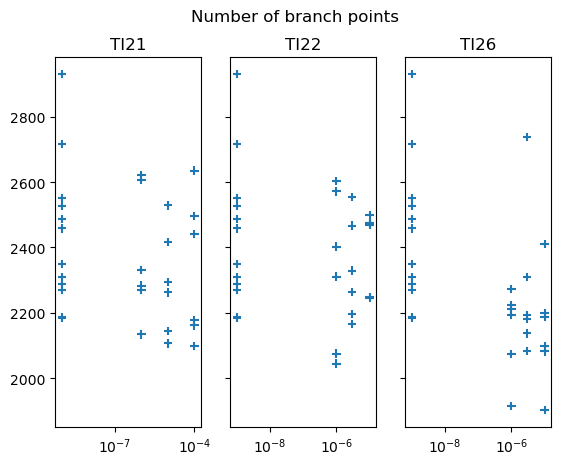

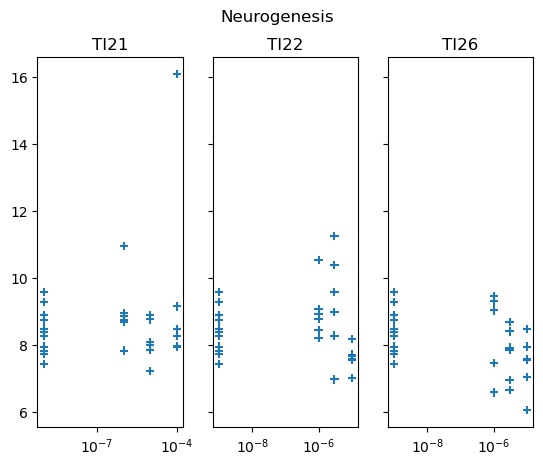

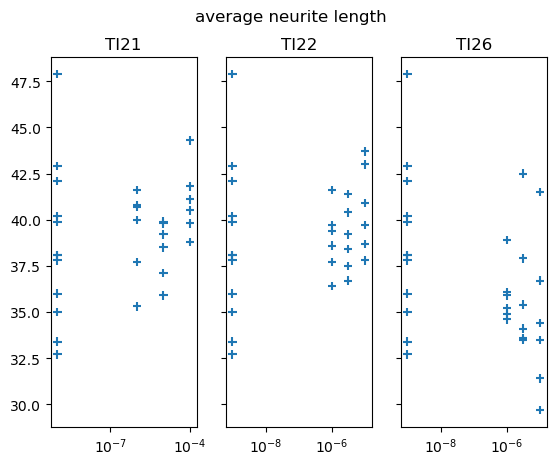

In [17]:
for assay in assays_NOG:
    fig, ax = data_plotter(assay, datad['NOG'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace(' ', '-').replace('/', '-'))

In [18]:
fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum-controls.csv'
controls = pd.read_csv(fpath, index_col='experiment')
controls

,control_treatment,group_var,TI21,TI22,TI26
experiment,,,,,
LPS,LPS,Cohort,2.0,3.0,5.0
Abeta Toxicity,LC,NaN,NaN,NaN,NaN
Abeta release,VC,plate,1.0,1.0,5.0
Abeta clearance,Aß,plate,2.0,3.0,5.0
GF withdrawal,VC,NaN,NaN,NaN,NaN
Tau phosphorylation,VC,NaN,NaN,NaN,NaN
NOG,VC,NaN,NaN,NaN,NaN


In [19]:
def extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=False):
    data = datad[exper]
    group_var, control_treatment, group_level = controls.loc[exper, ['group_var', 'control_treatment', compound]]
    mask = data.TI.isin([compound, control_treatment])
    if group_var is not np.nan:
        mask = mask & (data[group_var] == group_level)
    data = data.loc[mask]
    data_reshaped = data[[assay, 'concentration', 'conc_log10']]
    activity = data_reshaped[assay] / data_reshaped[assay].std() * 10
    data_reshaped = pd.concat([data_reshaped, activity.to_frame('activity')], axis=1)
    if return_data_reshaped:
        return(data_reshaped)
    y_obs = data_reshaped['activity'].values
    x_obs = data_reshaped['conc_log10'].values
    return((y_obs, x_obs))

extract_regr_data('Abeta clearance', 'Aβ42 Ly', 'TI21', return_data_reshaped=True)

,Aβ42 Ly,concentration,conc_log10,activity
0,23798.0,1.000000e-04,-4.0,19.181481
1,48934.0,1.000000e-04,-4.0,39.441407
2,16946.0,1.000000e-04,-4.0,13.658685
3,56506.0,1.000000e-04,-4.0,45.544532
4,24963.0,1.000000e-04,-4.0,20.120486
5,15538.0,1.000000e-04,-4.0,12.523819
8,21978.0,1.000000e-05,-5.0,17.714539
9,11275.0,1.000000e-05,-5.0,9.087789
10,14386.0,1.000000e-05,-5.0,11.595293
11,18214.0,1.000000e-05,-5.0,14.680708


In [20]:
exper = 'Abeta release'
assay = 'Aβ40'
compound = 'TI21'
data_reshaped = extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=True)
model_2, idata_2 = [cba.sample_sigmoid_2(*extract_regr_data(exper, assay, compound), return_model=b) for b in [True, False]]
model_4, idata_4 = [cba.sample_sigmoid_4(*extract_regr_data(exper, assay, compound), return_model=b) for b in [True, False]]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [21]:
model_names = ['sigmoid 2', 'sigmoid 4']
idatas = [idata_2, idata_4]
var_names = ['EC_50', 'y_0', 'FC_y', 'k', 'y_1']
pd.concat([az.ess(idata, var_names=var_names).to_pandas().to_frame((assay, compound, m)) for idata, m in zip(idatas, model_names)], axis=1)

Aβ40             
              TI21             
         sigmoid 2    sigmoid 4
EC_50  1272.835809  1957.623567
y_0    1390.967775  2080.717628
FC_y   1547.588025  1863.473140
k       543.651256   993.531127
y_1    1684.189393  1819.407554

In [22]:
pd.concat([az.rhat(idata, var_names=var_names).to_pandas().to_frame((assay, compound, m)) for idata, m in zip(idatas, model_names)], axis=1)

Aβ40          
           TI21          
      sigmoid 2 sigmoid 4
EC_50  1.003560  1.006128
y_0    1.004124  1.000926
FC_y   1.002939  1.002527
k      1.007925  1.007341
y_1    1.001692  1.003008

In [23]:
pd.concat([az.mcse(idata, var_names=var_names).to_pandas().to_frame((assay, compound, m)) for idata, m in zip(idatas, model_names)], axis=1)

Aβ40          
           TI21          
      sigmoid 2 sigmoid 4
EC_50  0.010286  0.010693
y_0    0.076734  0.131696
FC_y   0.002667  0.002749
k      2.348334  0.644168
y_1    0.085399  0.121159

['named-figure/mcmc-trace-sigmoid-2.png',
 'named-figure/mcmc-trace-sigmoid-2.pdf']

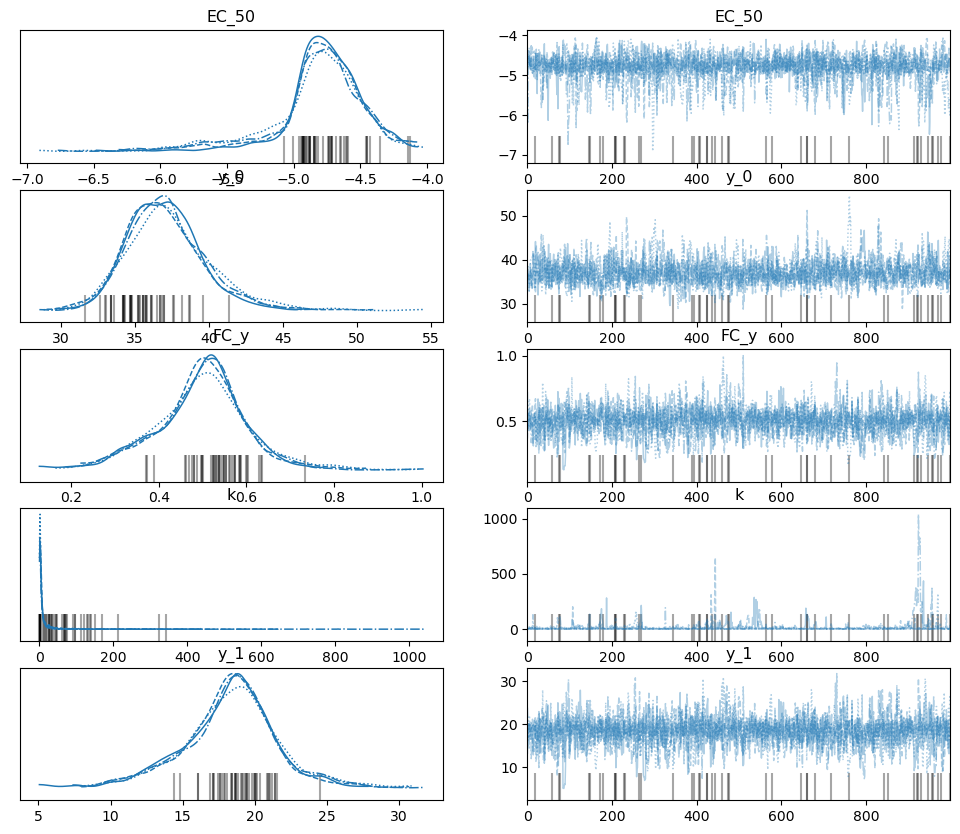

In [24]:
ax = az.plot_trace(idata_2, var_names=var_names)
fig = ax[0, 0].figure
attila_utils.savefig(fig, 'mcmc-trace-sigmoid-2')

['named-figure/mcmc-autocorr-sigmoid-2.png',
 'named-figure/mcmc-autocorr-sigmoid-2.pdf']

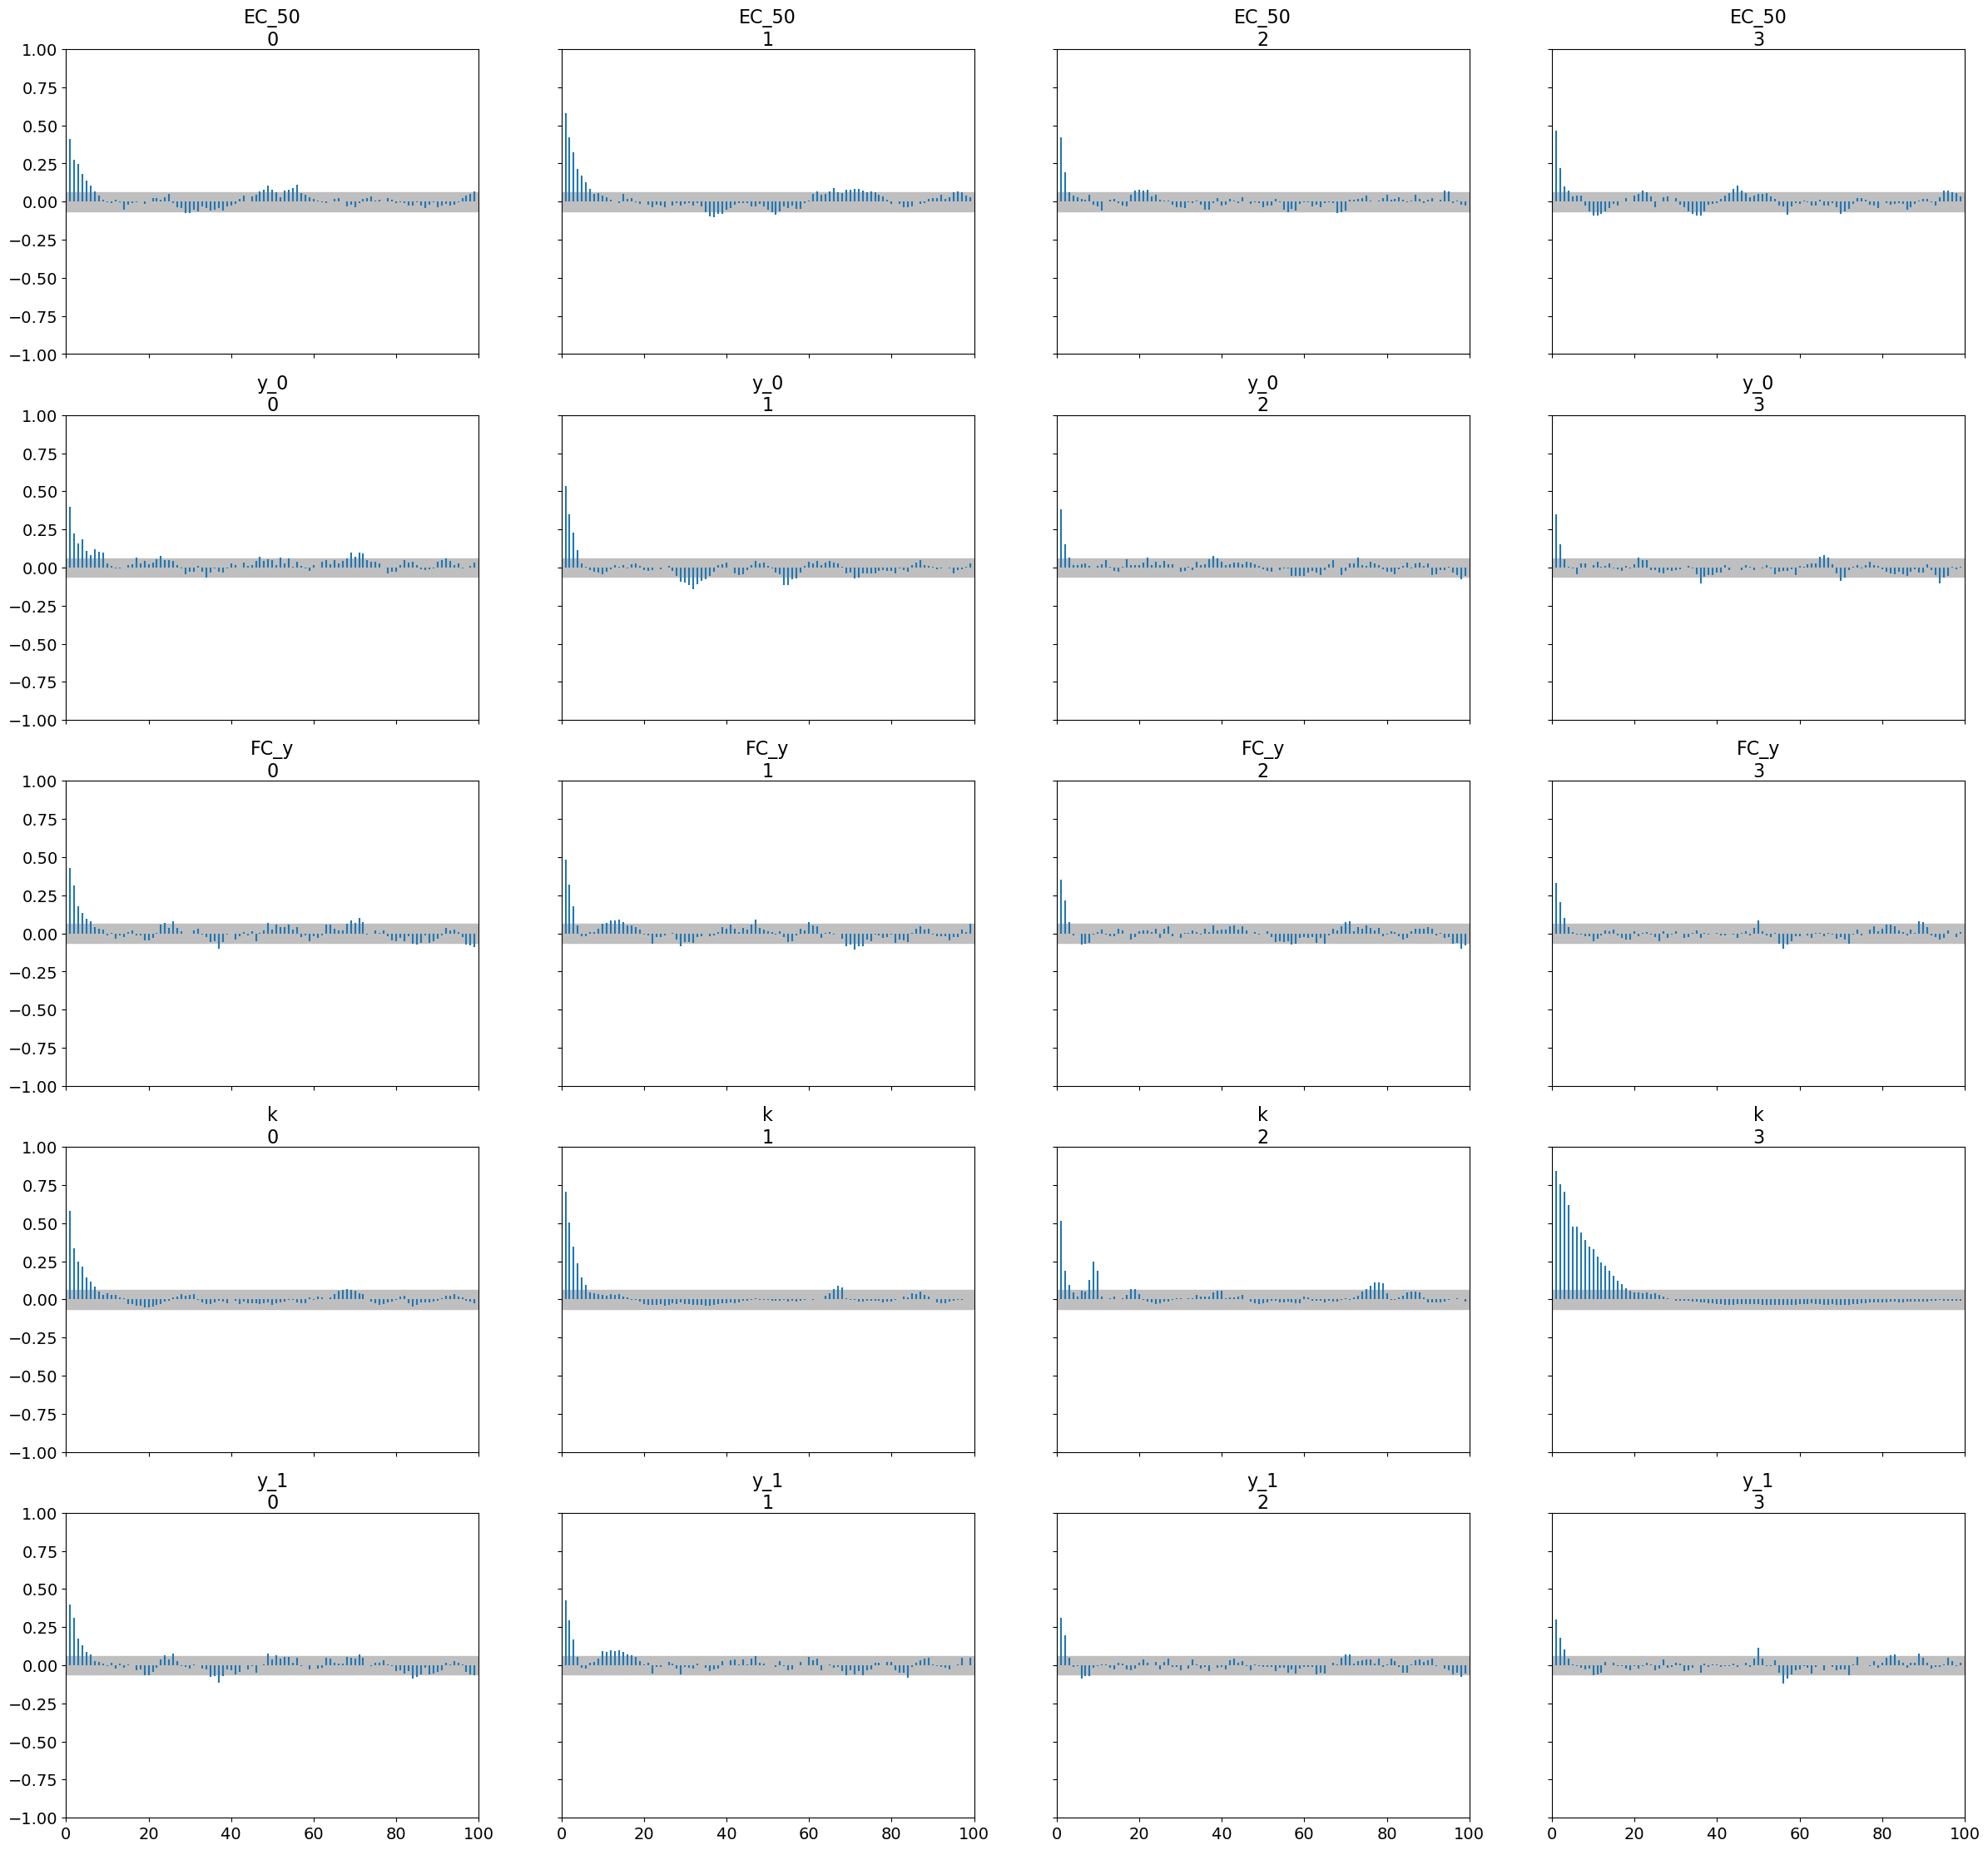

In [25]:
ax = az.plot_autocorr(idata_2, var_names=var_names)
fig = ax[0, 0].figure
attila_utils.savefig(fig, 'mcmc-autocorr-sigmoid-2')

['named-figure/mcmc-autocorr-sigmoid-2.png',
 'named-figure/mcmc-autocorr-sigmoid-2.pdf']

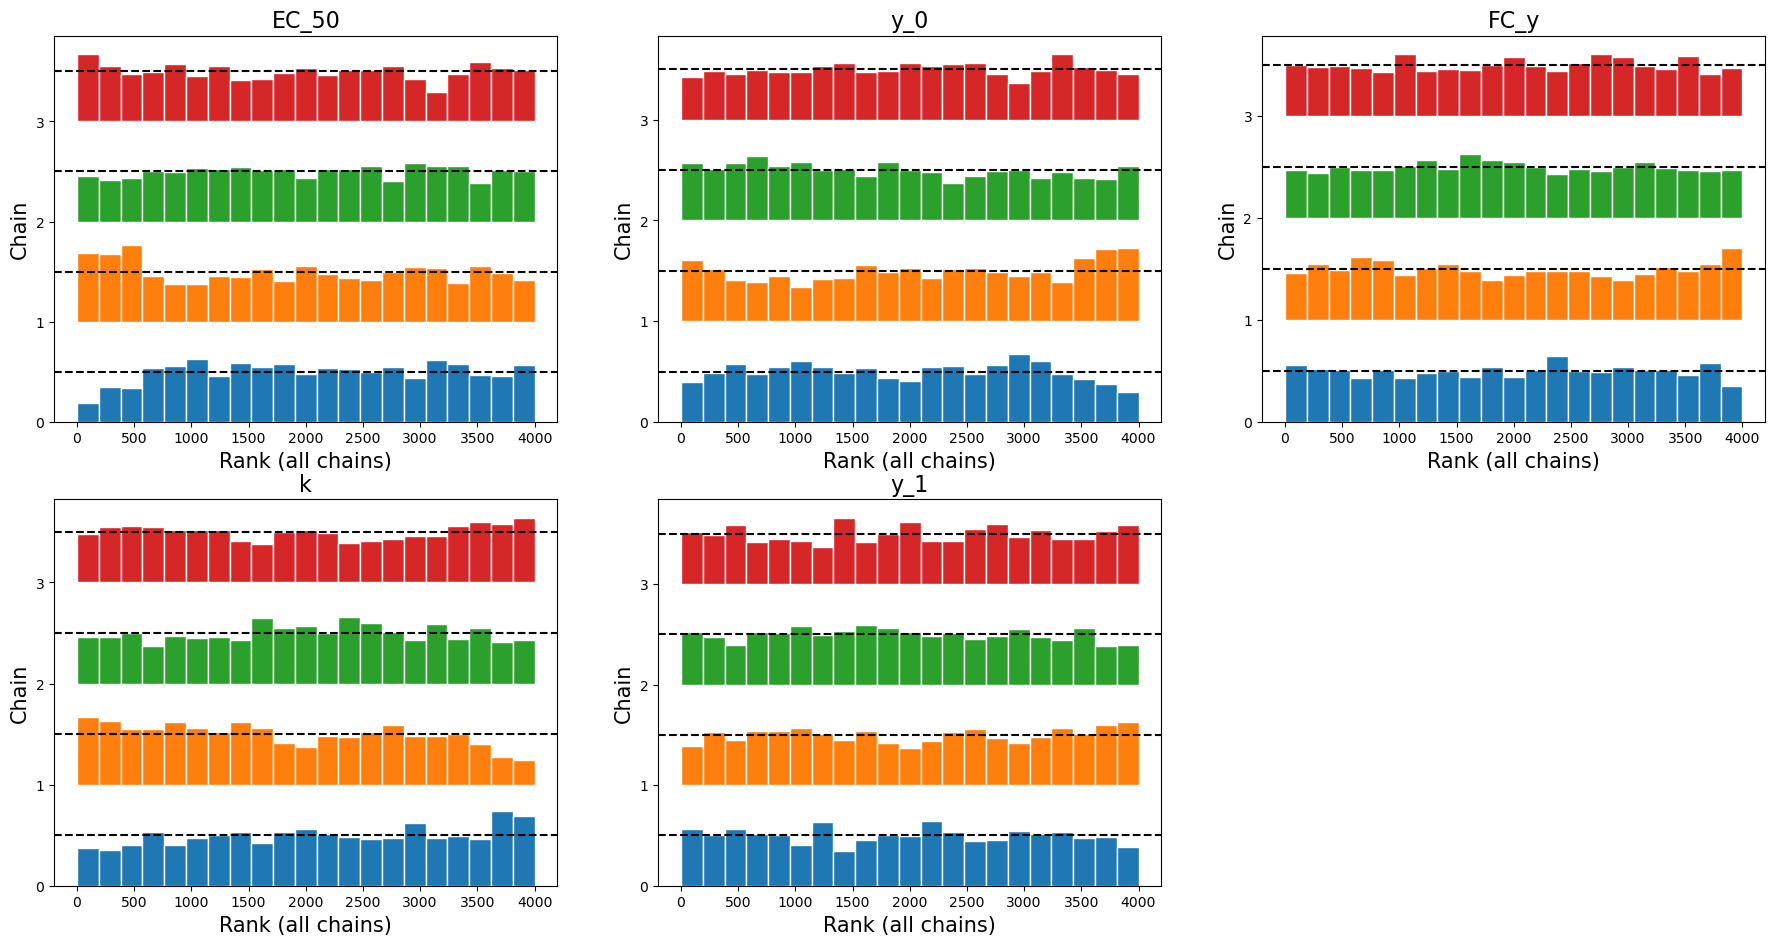

In [26]:
az.plot_rank(idata_2, var_names=var_names)
fig = ax[0, 0].figure
attila_utils.savefig(fig, 'mcmc-autocorr-sigmoid-2')

In [27]:
prior_samples_2, prior_samples_4 = [pm.sample_prior_predictive(1000, model) for model in [model_2, model_4]]

Sampling: [EC_50, FC_y, k, y, y_0, σ]
Sampling: [EC_50, FC_y, k, y, y_0, α, β]


Sampling: [EC_50, FC_y, k, y, y_0, σ]
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:247: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))


['named-figure/prior-posterior-curves-sigmoid-2.png',
 'named-figure/prior-posterior-curves-sigmoid-2.pdf']

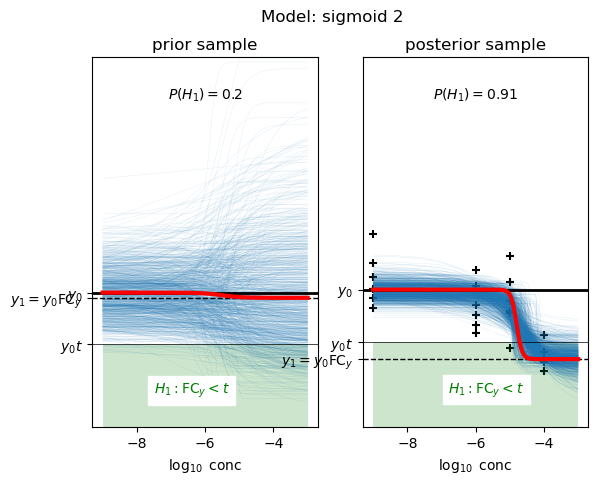

In [28]:
def prior_posterior_curves(model, idata, data_reshaped):
    H1_posterior_prob = cba.get_H1_posterior_prob(idata.posterior['FC_y'], H1_increase=False, H1_prior_prob=cba.default_H1_prior_prob)
    prior = pm.sample_prior_predictive(1000, model, random_seed=1986).prior
    fig, ax = plt.subplots(1, 2, sharey=False)
    for axi, data, title in zip(ax, [prior, idata.posterior], ['prior sample', 'posterior sample']):
        if title == 'posterior sample':
            axi = cba.plot_data(axi, data_reshaped)
            H1_prob = H1_posterior_prob
        else:
            H1_prob = cba.default_H1_prior_prob
        axi = cba.plot_sampled_curves_sigmoid(ax=axi, idata=data, data_reshaped=data_reshaped, alpha=0.2, draw_y0_y1=True)
        axi.axhline(0, color='k', linewidth=0.5)
        axi.set_title(title)
        axi.set_ylim(0, 100)
        axi.set_ylabel('')
        axi.text(0.5, 0.9, '$P(H_1) = {:.2g}$'.format(H1_prob), horizontalalignment='center', verticalalignment='center', transform=axi.transAxes)
    return((fig, ax))

fig, ax = prior_posterior_curves(model_2, idata_2, data_reshaped)
fig.suptitle('Model: sigmoid 2')
attila_utils.savefig(fig, 'prior-posterior-curves-sigmoid-2')

Sampling: [EC_50, FC_y, k, y, y_0, α, β]
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:247: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))


['named-figure/prior-posterior-curves-sigmoid-4.png',
 'named-figure/prior-posterior-curves-sigmoid-4.pdf']

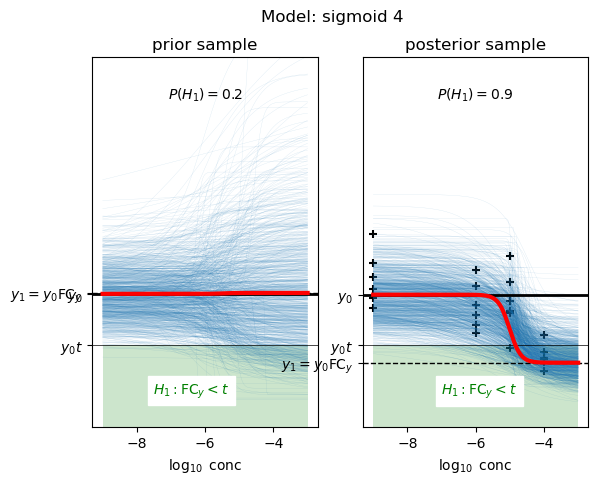

In [29]:
fig, ax = prior_posterior_curves(model_4, idata_4, data_reshaped)
fig.suptitle('Model: sigmoid 4')
attila_utils.savefig(fig, 'prior-posterior-curves-sigmoid-4')

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:321: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:324: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]


['named-figure/prior-posterior-density-complex-sigmoid-2.png',
 'named-figure/prior-posterior-density-complex-sigmoid-2.pdf']

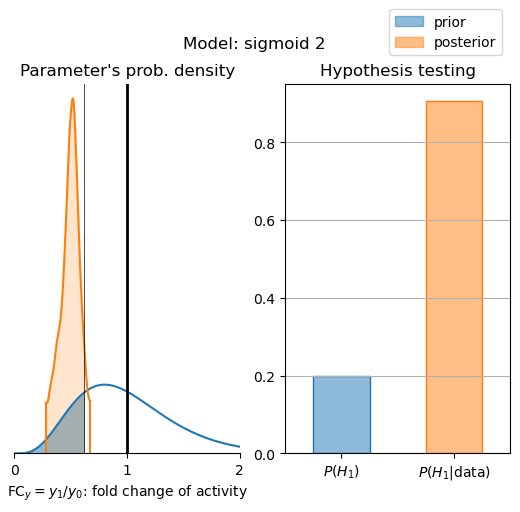

In [30]:
fig, ax = cba.prior_posterior_density_plot_complex(idata_2)
fig.suptitle('Model: sigmoid 2')
ylim_01 = 5.25
ax[0].set_ylim(0, ylim_01)
ylim_11 = 0.95
ax[1].set_ylim(0, ylim_11)
ax[1].grid(axis='y')
attila_utils.savefig(fig, 'prior-posterior-density-complex-sigmoid-2')

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:321: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=10)
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:324: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [mpatches.Patch(edgecolor=c, color=c, alpha=alpha) for c in ['C0', 'C1']]


['named-figure/prior-posterior-density-complex-sigmoid-4.png',
 'named-figure/prior-posterior-density-complex-sigmoid-4.pdf']

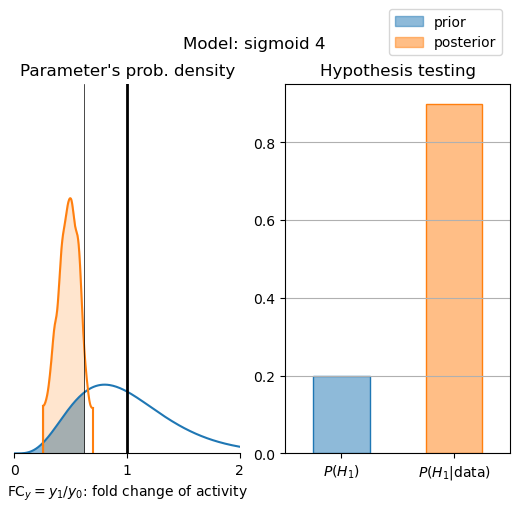

In [31]:
fig, ax = cba.prior_posterior_density_plot_complex(idata_4)
fig.suptitle('Model: sigmoid 4')
ax[0].set_ylim(0, ylim_01)
ax[1].set_ylim(0, ylim_11)
ax[1].grid(axis='y')
attila_utils.savefig(fig, 'prior-posterior-density-complex-sigmoid-4')

In [32]:
prior = 0.2
cba.get_H1_posterior_prob(idata_2.posterior['FC_y'], H1_increase=False, H1_prior_prob=prior)

0.907

In [33]:
def posteriors_priors(idata, model_name):
    #priors = np.arange(0.1, 0.6, 0.2)
    priors = 10 ** np.linspace(-2, 0, 9)
    l = [cba.get_H1_posterior_prob(idata.posterior['FC_y'], H1_increase=False, H1_prior_prob=prior) for prior in priors]
    df = pd.DataFrame(l, index=priors, columns=[model_name])
    return(df)

posteriors_priors_example = pd.concat([posteriors_priors(idata, model_name) for idata, model_name in zip([idata_2, idata_4], model_names)], axis=1)
posteriors_priors_example['prior'] = posteriors_priors_example.index
posteriors_priors_example

,sigmoid 2,sigmoid 4,prior
0.010000,0.01500,0.02625,0.010000
0.017783,0.03325,0.05450,0.017783
0.031623,0.08250,0.11450,0.031623
0.056234,0.18025,0.24325,0.056234
0.100000,0.41475,0.50350,0.100000
0.177828,0.85725,0.84925,0.177828
0.316228,0.98900,0.97900,0.316228
0.562341,0.99975,0.99800,0.562341
1.000000,1.00000,1.00000,1.000000


['named-figure/H1-prob-posterior-vs-prior.png',
 'named-figure/H1-prob-posterior-vs-prior.pdf']

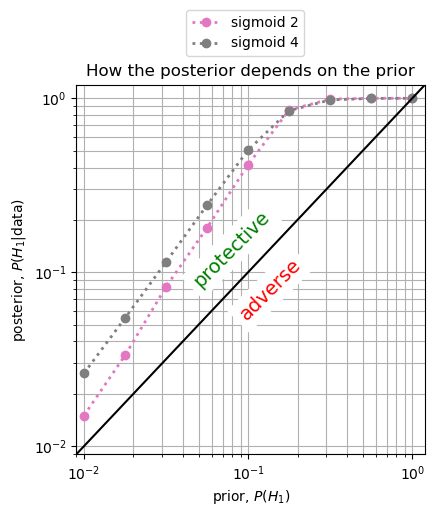

In [34]:
fig, ax = plt.subplots(figsize=(4.5, 4.8))
for p, color in zip(model_names, ['C6', 'C7']):
    ax.plot('prior', p, data=posteriors_priors_example, marker='o', linestyle='dotted', linewidth=2, color=color)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('prior, $P(H_1)$')
ax.set_ylabel('posterior, $P(H_1 | \mathrm{data})$')
ax.set_title('How the posterior depends on the prior')
lim_0 = posteriors_priors_example.min().min() * 0.9
lim_1 = 1.2
ax.set_xlim(lim_0, lim_1)
ax.set_ylim(lim_0, lim_1)
ax.axline((lim_0, lim_0), (lim_1, lim_1), color='k')
ax.grid(which='both')
x_0_min = 4/9
for x_0, my_text, color in zip([x_0_min, 1 - x_0_min], ['protective', 'adverse'], ['green', 'red']):
    ax.text(x_0, 1 - x_0, my_text, horizontalalignment='center', verticalalignment='center',
            rotation=45, transform=ax.transAxes, fontsize=14, color=color, backgroundcolor='white')

attila_utils.savefig(fig, 'H1-prob-posterior-vs-prior')

In [35]:
def fit_single(exper='Abeta release', assay='Aβ38', compound='TI21', datad=datad, controls=controls):
    data_reshaped = extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=True)
    try:
        model, idata = [cba.sample_sigmoid_2(*extract_regr_data(exper, assay, compound), return_model=b) for b in [True, False]]
    except pm.SamplingError:
        model, idata = (None, None)
    index = pd.MultiIndex.from_product([[compound], ['model', 'idata']])
    columns = pd.MultiIndex.from_product([[exper], [assay]])
    df = pd.DataFrame([model, idata], index=index, columns=columns).transpose()
    return(df)


#df = fit_single(exper='LPS', assay='IL-4', compound='TI22')
#df = fit_single(exper='Abeta release', assay='Aβ38', compound='TI21')
#df

In [36]:
def fit_assay(exper='Abeta release', assay='Aβ38', datad=datad, controls=controls, compounds=['TI21', 'TI22', 'TI26']):
    l = [fit_single(exper=exper, assay=assay, compound=c, datad=datad, controls=controls) for c in compounds]
    df = pd.concat(l, axis=1)
    return(df)

#ddf = fit_assay(exper='Abeta release', assay='Aβ38')
#ddf

In [37]:
def fit_exper(exper='Abeta release', datad=datad, controls=controls, assays=assays_Ab_release, compounds=['TI21', 'TI22', 'TI26']):
    l = [fit_assay(exper=exper, assay=a, datad=datad, controls=controls, compounds=compounds) for a in assays]
    df = pd.concat(l, axis=0)
    return(df)

#dddf = fit_exper(exper='Abeta release', assays=assays_Ab_release)
#dddf

In [38]:
with open('../../results/2023-09-13-cell-based-assays-bayes/experiments.csv', 'rb') as f:
    experiments = pickle.load(f).drop('TI1', axis=0, level=2)

if False: # True is test mode
    e1 = 'Abeta clearance, iPSC'
    e2 = 'LPS neuroinflammation, iPSC'
    experiments = experiments.loc[[(e1, 'pHrodo-number-4h', 'TI21'), (e1, 'pHrodo-number-4h', 'TI26'), (e2, 'IL-1b', 'TI26')]]

def idatadf_to_netcdf(idatadf, subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/'):
    dirname = maindir + subdir
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    data = idatadf.stack().to_frame('idata')
    l = [dirname + 'idata-' + str(i) + '.nc' for i in np.arange(len(data))]
    fpathdf = pd.DataFrame({'fpath': l}, index=data.index)
    fpathdf.to_csv(maindir + subdir + 'fpaths.csv')
    idata_saveloc = pd.concat([data, fpathdf], axis=1)
    idata_saveloc.apply(lambda r: r.loc['idata'].to_netcdf(r.loc['fpath']), axis=1)
    return(fpathdf)

def idatadf_from_netcdf(subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/'):
    fpathdf = pd.read_csv(maindir + subdir + 'fpaths.csv', index_col=[0,1,2])
    val = fpathdf.apply(lambda row: az.from_netcdf(row.loc['fpath']), axis=1)
    val = val.unstack(level=2).reindex(fpathdf.xs(fpathdf.index.get_level_values(2)[0], axis=0, level=2).index)
    return(val)

if not os.path.exists('../../results/2023-09-26-cell-bayes-assays/idatadf/fpaths.csv'):
    l = [fit_exper(exper=exper, assays=assays) for exper, assays in assayd.items()]
    idata_nonipsc = pd.concat(l, axis=0)
    idata_ipsc = cba.fit_models(models=['sigmoid 2'], experiments=experiments)
    idata_ipsc = idata_ipsc.unstack().swaplevel(1, 2, axis=1).sort_index(level=2, axis=1, ascending=True).sort_index(level=1, axis=1).xs('sigmoid 2', level=0, axis=1)
    blank = pd.DataFrame(np.reshape(np.repeat(None, idata_ipsc.shape[0] * 2), [idata_ipsc.shape[0], 2]), index=idata_ipsc.index, columns=pd.MultiIndex.from_product([['TI22'], ['idata', 'model']]))
    idata_ipsc = pd.concat([idata_ipsc, blank], axis=1)
    idatadf = pd.concat([idata_nonipsc, idata_ipsc], axis=0).xs('idata', axis=1, level=1)
    fpathdf = idatadf_to_netcdf(idatadf, subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/')
    print('idatadf written to netcdf')
else:
    idatadf = idatadf_from_netcdf(subdir='idatadf/', maindir='../../results/2023-09-26-cell-bayes-assays/')
    print('idatadf read from netcdf')

idatadf

idatadf read from netcdf


TI21  \
LPS                         IFN-γ                    (posterior, log_likelihood, sample_stats, obse...   
                            IL-10                    (posterior, log_likelihood, sample_stats, obse...   
                            IL-12p70                 (posterior, log_likelihood, sample_stats, obse...   
                            IL-1β                    (posterior, log_likelihood, sample_stats, obse...   
                            IL-2                     (posterior, log_likelihood, sample_stats, obse...   
                            IL-4                     (posterior, log_likelihood, sample_stats, obse...   
                            IL-5                     (posterior, log_likelihood, sample_stats, obse...   
                            IL-6                     (posterior, log_likelihood, sample_stats, obse...   
                            KC/GRO                   (posterior, log_likelihood, sample_stats, obse...   
                            TNF-α                    (posterior, log_likelihood, sample_stats, obse...   
Abeta Toxicity              Viability [% VC]         (posterior, log_likelihood, sample_stats, obse...   
Abeta release               Aβ38                     (posterior, log_likelihood, sample_stats, obse...   
                            Aβ40                     (posterior, log_likelihood, sample_stats, obse...   
                            Aβ42                     (posterior, log_likelihood, sample_stats, obse...   
Abeta clearance             Aβ42 SN                  (posterior, log_likelihood, sample_stats, obse...   
                            Aβ42 Ly                  (posterior, log_likelihood, sample_stats, obse...   
GF withdrawal               PI                       (posterior, log_likelihood, sample_stats, obse...   
                            YOPRO                    (posterior, log_likelihood, sample_stats, obse...   
                            MTT                      (posterior, log_likelihood, sample_stats, obse...   
                            LDH                      (posterior, log_likelihood, sample_stats, obse...   
Tau phosphorylation         Tau [pg/µg prot]         (posterior, log_likelihood, sample_stats, obse...   
                            pTau (T231)              (posterior, log_likelihood, sample_stats, obse...   
                            ratio                    (posterior, log_likelihood, sample_stats, obse...   
NOG                         total neurite length     (posterior, log_likelihood, sample_stats, obse...   
                            Number of branch points  (posterior, log_likelihood, sample_stats, obse...   
                            Neurogenesis             (posterior, log_likelihood, sample_stats, obse...   
                            average neurite length   (posterior, log_likelihood, sample_stats, obse...   
Abeta clearance, iPSC       pHrodo-number-4h         (posterior, log_likelihood, sample_stats, obse...   
                            supernatant              (posterior, log_likelihood, sample_stats, obse...   
LPS neuroinflammation, iPSC IL-1b                    (posterior, log_likelihood, sample_stats, obse...   
                            IL-6                     (posterior, log_likelihood, sample_stats, obse...   
                            IL-8                     (posterior, log_likelihood, sample_stats, obse...   
                            MTT                      (posterior, log_likelihood, sample_stats, obse...   
                            TNF                      (posterior, log_likelihood, sample_stats, obse...   

                                                                                                  TI22  \
LPS                         IFN-γ                    (posterior, log_likelihood, sample_stats, obse...   
                            IL-10                    (posterior, log_likelihood, sample_stats, obse...   
                            IL-12p70                 (posterior, log_

In [39]:
def get_diagnostics(fun=az.ess, var_names=var_names, idatadf=idatadf, return_df=False):
    def helper(x, var):
        if x in [np.nan, None]:
            return(x)
        else:
            return(fun(x, var_names=var).to_dict()['data_vars'][var]['data'])
    #idat = idatadf.xs('idata', axis=1, level=1)
    def my_applymap(var, idatadf):
        df = idatadf.applymap(lambda x: helper(x, var))
        df.columns = pd.MultiIndex.from_product([df.columns, [var]])
        return(df)
    df = pd.concat([my_applymap(var, idatadf) for var in var_names], axis=1)
    df = df.sort_index(axis=1, level=0)
    if return_df:
        return(df)
    precision = np.int64(3 - np.round(np.log10(df.mean().mean())))
    val = df.style.format(precision=precision).background_gradient(axis=None, vmin=df.min().min(), vmax=df.max().max(), cmap='hot')
    return(val)

get_diagnostics(fun=az.ess)

In [40]:
get_diagnostics(fun=az.rhat)

In [41]:
get_diagnostics(fun=az.mcse)

In [42]:
poor_fits = [
    (('LPS', 'IFN-γ'), 'TI26'),
    (('LPS', 'IL-4'), 'TI22'),
    (('Tau phosphorylation', 'ratio'), 'TI22'),
    (('NOG', 'Neurogenesis'), 'TI22'),
]

def remove_poorly_fitted(df, replace_val=None, poor_fits=poor_fits):
    data = df.copy()
    for x in poor_fits:
        ix, column = x
        data.loc[ix, column] = replace_val
    return(data)

In [43]:
ideal_H1_increase = pd.read_csv('ideal-effects.csv', index_col=['experiment', 'assay'], usecols=['experiment', 'assay', 'H1_increase', 'ideal effect'])
ideal_H1_increase['H2_increase'] = ~ ideal_H1_increase.H1_increase
ideal_H1_increase

ideal effect  H1_increase  \
experiment                  assay                                               
LPS                         IFN-γ                       decrease        False   
                            IL-10                       decrease        False   
                            IL-12p70                    decrease        False   
                            IL-1β                       decrease        False   
                            IL-2                        decrease        False   
                            IL-4                        decrease        False   
                            IL-5                        decrease        False   
                            IL-6                        decrease        False   
                            KC/GRO                      decrease        False   
                            TNF-α                       decrease        False   
Abeta Toxicity              Viability [% VC]            increase         True   
Abeta release               Aβ38                        decrease        False   
                            Aβ40                        decrease        False   
                            Aβ42                        decrease        False   
Abeta clearance             Aβ42 SN                     decrease        False   
                            Aβ42 Ly                     increase         True   
GF withdrawal               PI                          decrease        False   
                            YOPRO                       decrease        False   
                            MTT                         increase         True   
                            LDH                         decrease        False   
Tau phosphorylation         Tau [pg/µg prot]            increase         True   
                            pTau (T231)                 decrease        False   
                            ratio                       decrease        False   
NOG                         total neurite length        increase         True   
                            Number of branch points     increase         True   
                            Neurogenesis                increase         True   
                            average neurite length      increase         True   
Abeta clearance, iPSC       pHrodo-number-4h            increase         True   
                            supernatant                 decrease        False   
LPS neuroinflammation, iPSC IL-1b                       decrease        False   
                            IL-6                        decrease        False   
                            IL-8                        decrease        False   
                            MTT                         decrease        False   
                            TNF                         decrease        False   

                                                     H2_increase  
experiment                  assay                                 
LPS                         IFN-γ                           True  
                            IL-10                           True  
                            IL-12p70                        True  
                            IL-1β                           True  
                            IL-2                            True  
                            IL-4                            True  
                            IL-5                            True  
                            IL-6                            True  
                            KC/GRO                          True  
                            TNF-α                           True  
Abeta Toxicity              Viability [% VC]               False  
Abeta release               Aβ38                            True  
                            Aβ40                            True  
                            Aβ42                            True  
Abeta clearance             Aβ42 SN                         Tru

In [44]:
def get_H1_posterior_from_idatadf(idatadf, hypothesis='H1', ideal_H1_increase=ideal_H1_increase):
    data = remove_poorly_fitted(idatadf)
    ll = [[cba.get_H1_posterior_prob(data.loc[ix, drug].posterior['FC_y'], H1_increase=ideal_H1_increase.loc[ix, hypothesis + '_increase']) if data.loc[ix, drug] is not None else None for drug in data.columns] for ix in data.index]
    H1_posteriors = pd.DataFrame(ll, index=data.index, columns=pd.MultiIndex.from_product([data.columns, [hypothesis]]))
    return(H1_posteriors)

def get_H102_posterior_from_idatadf(idatadf, ideal_H1_increase=ideal_H1_increase):
    H1_posteriors, H2_posteriors = [get_H1_posterior_from_idatadf(idatadf, hypothesis=h, ideal_H1_increase=ideal_H1_increase) for h in ['H1', 'H2']]
    a = 1 - (H1_posteriors.to_numpy() + H2_posteriors.to_numpy())
    H0_posteriors = pd.DataFrame(a, index=idatadf.index, columns=pd.MultiIndex.from_product([idatadf.columns, ['H0']]))
    H102_posteriors = pd.concat([H1_posteriors, H0_posteriors, H2_posteriors], axis=1).sort_index(axis=1, level=0)
    hypotheses = ['H1', 'H0', 'H2']
    columns = pd.MultiIndex.from_product([idatadf.columns, pd.CategoricalIndex(hypotheses, categories=hypotheses, ordered=True)])
    H102_posteriors = H102_posteriors.reindex(columns=columns)
    return(H102_posteriors)

fpath = '../../results/2023-09-26-cell-bayes-assays/H102_posteriors.csv'
if not os.path.exists(fpath):
    H102_posteriors = get_H102_posterior_from_idatadf(idatadf)
    H102_posteriors.to_csv(fpath)
else:
    H102_posteriors = pd.read_csv(fpath, index_col=[0, 1], header=[0, 1])
    
H102_posteriors.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='hot')

In [45]:
H102_posteriors.mean(axis=0).to_frame('score').transpose().style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='hot')

In [46]:
def plot_sampled_curves_all_compounds(exper='LPS', assay='IFN-γ', idatadf=idatadf,
                                      ideal_H1_increase=ideal_H1_increase, experiments=experiments):
    fig, ax = plt.subplots(1, idatadf.shape[1], sharey=True)
    for axi, compound in zip(ax, idatadf.columns):
        if idatadf.loc[(exper, assay), compound] is None:
            continue
        idata = idatadf.loc[(exper, assay), compound].posterior
        if exper in ['Abeta clearance, iPSC', 'LPS neuroinflammation, iPSC']:
            concentrations, bname = [experiments.loc[(exper, assay, compound), c] for c in ['concentrations', 'bname']]
            data_reshaped = cba.read_reshape_data(compound, assay, concentrations, bname)
        else:
            data_reshaped = extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=True)
        axi = cba.plot_sampled_curves_sigmoid(axi, idata, data_reshaped)
        axi = cba.plot_data(axi, data_reshaped)
        axi.set_title(compound)
    ideal_effect = ideal_H1_increase.loc[(exper, assay), 'ideal effect']
    fig.suptitle(assay + ', ' + exper + ', desired ' + ideal_effect)
    return(fig)

#plot_sampled_curves_all_compounds(exper='Abeta clearance, iPSC', assay='pHrodo-number-4h')

In [47]:
for ix in idatadf.index:
    exper, assay = ix
    fname = 'posterior-curves-' + exper + '-' + assay
    fname = fname.replace('/', '-').replace(' ', '-')
    if not os.path.exists('named-figure/' + fname + '.pdf'):
        fig = plot_sampled_curves_all_compounds(exper, assay)
        attila_utils.savefig(fig, fname)

In [48]:
exper='LPS'
assay='IFN-γ'
compound='TI21'
FC_y_max=5
npoints=400
#idat=idatadf.xs('idata', axis=1, level=1)
posterior = idatadf.loc[(exper, assay), compound].posterior
l = list(itertools.chain(*posterior['FC_y'].to_numpy()))
k = scipy.stats.gaussian_kde(l)
xx = np.linspace(0, FC_y_max, npoints)
yy = k.evaluate(xx)

In [49]:
def get_FC_y_posterior_sample(exper='LPS', assay='IFN-γ', compound='TI21', idatadf=idatadf):
    H1_increase = ideal_H1_increase.loc[(exper, assay), 'H1_increase']
    idata = idatadf.loc[(exper, assay), compound]
    if idata in [np.nan, None]:
        idata = idatadf.dropna().iloc[0,0]
        npoints = len(idata.sample_stats['chain']) * len(idata.sample_stats['draw'])
        l = np.repeat(np.nan, npoints)
        #return(None)
    else:
        posterior = idata.posterior
        l = list(itertools.chain(*posterior['FC_y'].to_numpy()))
    df = pd.DataFrame({'FC_y': l, 'exper': exper, 'assay': assay, 'compound': compound, 'H1_increase': H1_increase})
    return(df)

def get_FC_y_posterior_sample_all(idatadf=idatadf):
    ll = [[get_FC_y_posterior_sample(exper, assay, compound, idatadf) for exper, assay in idatadf.index] for compound in my_treatments]
    l = list(itertools.chain(*ll))
    df = pd.concat(l, axis=0)
    return(df)

get_FC_y_posterior_sample_all(idatadf=remove_poorly_fitted(idatadf))

,FC_y,exper,assay,compound,H1_increase
0,1.301145,LPS,IFN-γ,TI21,False
1,1.390173,LPS,IFN-γ,TI21,False
2,2.326184,LPS,IFN-γ,TI21,False
3,1.520196,LPS,IFN-γ,TI21,False
4,1.417149,LPS,IFN-γ,TI21,False
...,...,...,...,...,...
3995,0.177664,"LPS neuroinflammation, iPSC",TNF,TI26,False
3996,0.179678,"LPS neuroinflammation, iPSC",TNF,TI26,False
3997,0.369724,"LPS neuroinflammation, iPSC",TNF,TI26,False
3998,0.418108,"LPS neuroinflammation, iPSC",TNF,TI26,False


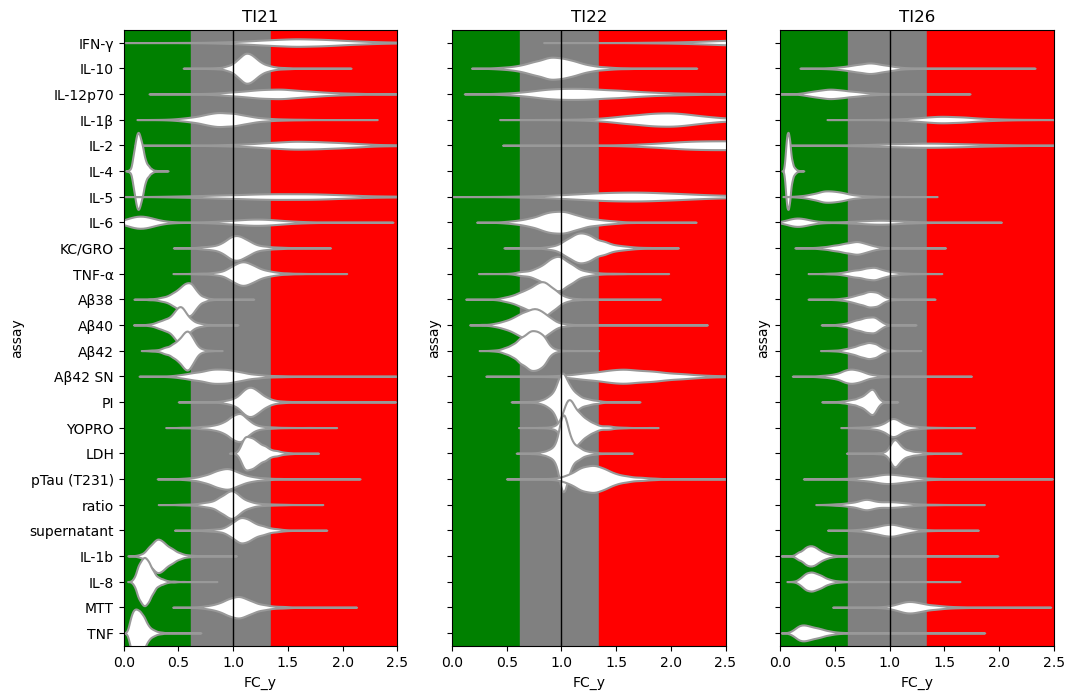

In [50]:
def violin_color_bg(ax, compound, H1_increase=False, return_data=False, idatadf=idatadf):
    df = get_FC_y_posterior_sample_all(idatadf=remove_poorly_fitted(idatadf))
    H1_mask = df.H1_increase if H1_increase else (~ df.H1_increase)
    data = df.loc[H1_mask & (df.compound == compound)]
    if return_data:
        return(data)
    nassays = np.unique(data.apply(lambda r: r.loc['exper'] + ', ' + r.loc['assay'], axis=1)).shape[0]
    t_H_lo = scipy.stats.gamma.ppf(cba.default_H1_prior_prob, cba.gamma_shape, scale=1/cba.gamma_shape)
    t_H_up = scipy.stats.gamma.ppf(1 - cba.default_H1_prior_prob, cba.gamma_shape, scale=1/cba.gamma_shape)
    H0_color = 'gray'
    H1_color = 'green'
    H2_color = 'red'
    color_up = H1_color if H1_increase else H2_color
    color_lo = H2_color if H1_increase else H1_color
    ax.add_patch(plt.Rectangle((0, -0.5), width=t_H_lo, height=nassays, color=color_lo))
    ax.add_patch(plt.Rectangle((t_H_lo, -0.5), width=t_H_up - t_H_lo, height=nassays, color=H0_color))
    x_right = 2.5
    ax.add_patch(plt.Rectangle((t_H_up, -0.5), width=x_right - t_H_up, height=nassays, color=color_up))
    ax.axvline(1, color='k', linewidth=1)
    sns.violinplot(data=data, y='assay', x='FC_y', width=3, ax=ax, inner=None, color='white', fill=True)
    ax.set_xlim(0, x_right)
    return(ax)

fig, ax = plt.subplots(1, 3, figsize=(12,8), sharey=True)
for axi, compound in zip(ax, my_treatments):
    axi = violin_color_bg(axi, compound, H1_increase=False)
    axi.set_title(compound)

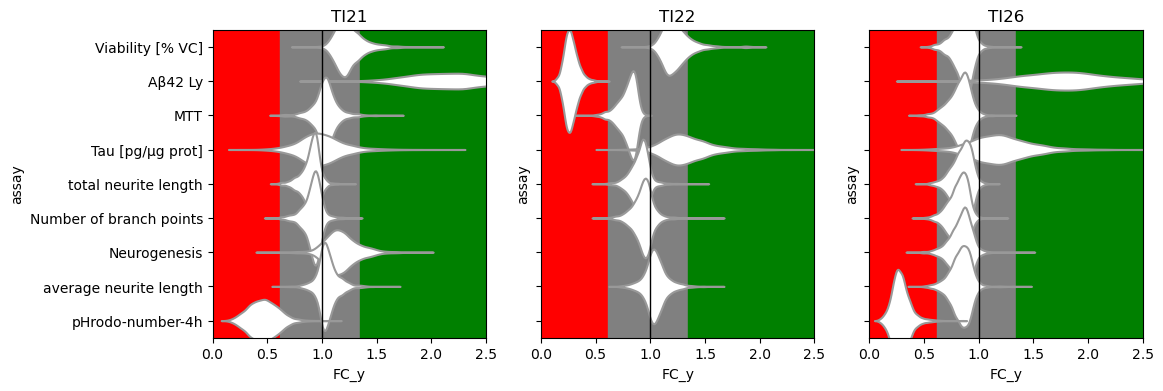

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
for axi, compound in zip(ax, my_treatments):
    axi = violin_color_bg(axi, compound, H1_increase=True)
    axi.set_title(compound)

In [52]:
%connect_info

{
  "shell_port": 54797,
  "iopub_port": 54798,
  "stdin_port": 54799,
  "control_port": 54801,
  "hb_port": 54800,
  "ip": "127.0.0.1",
  "key": "f440f37c-b81acd0e58fed9e1046c5f0d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-0ff66d66-1ea0-48fc-bbde-59ce6aeb8acc.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
